In [1]:
import numpy as np # to deal with arrays, linear algebra
import pandas as pd # data processing, manipulation

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from pathlib import Path # It simplifies working with file paths across different operating systems
from xml.dom.minidom import parse # If dealing with data stored in XML files, this allows us to load and manipulate that data in a structured way, 
# like navigating through elements and attributes of the XML document
from shutil import copyfile # to create a duplicate of a file, which can be helpful in situations where you need to back up data, move files around, or prepare data for further processing

# used for tasks like checking if a file exists, creating directories, or executing system commands from within python
import os

In [2]:
# Creating directories Dataset and labels directory inside
# it to store annotations and image to store images

!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [3]:
# Different labels model have to detect

classes = ['helmet','head','person']

In [4]:
# Normalization 
# to ensure that model's prediction is independent of image size
# YOLO algorithm require bounding box coordinates to be normalized to the range [0, 1]

# This function converts the bounding box from a corner-based format (x1, y1, x2, y2) to a center-based format (x, y, w, h)
# because it can be more convenient for regression tasks

# size is a tuple containing (width , height)
# box contains the coordinates x1, y1, x2, y2 


def convert_annot(size , box):

    # x1, y1 are the coordinates of top - left corner of the box
    # x2, y2 are the coordinates of bottom-right corner of the box
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    # inverse of image width and height
    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    # w width of image and h height of image 
    w = x2 - x1
    h = y2 - y1

    # center of image 
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    # normalizing the center, width, height between [0,1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh

    return [x, y, w, h]

In [5]:
# function is designed to save the bounding box annotations of objects detected in an image into a text file
# for object detection models, like YOLO (You Only Look Once), annotations are stored in text files

# size - width and height of the image
# img_box - A list of bounding box annotations 
# the coordinates of the bounding box around the detected object

def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/kaggle/working/Dataset/labels/' +  img_jpg_file_name + '.txt'
    
    # The file is opened in 'a+' mode ,
    # this mode allows the file to be opened for both reading and appending 
    # If the file doesn't exist, it will be created, 
    # The with statement ensures that the file is properly closed after writing, even if an error occurs

    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            # convert_annot function is called to convert these coordinates into a format suitable for saving, 
            # likely normalizing them relative to the image size
            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        # Although the file is automatically closed by the with statement, 
        # these lines ensure that any data still in the buffer is written to the disk (flush) before closing the file
        file_path.flush()
        file_path.close()

In [6]:
# get_xml_data is designed to extract data from an XML file that contains annotations for an image 
# and then save those annotations into a specific text format
#  YOLO, require annotations in a specific text format

# file_path is the directory where the XML file is located
# img_xml_file is the name of the XML file (without the .xml extension) 
# that contains the annotation data for a specific image.

def get_xml_data(file_path, img_xml_file):

    # constructs the full path to the XML file by combining the directory path (file_path) 
    # with the file name (img_xml_file) and the .xml extension.
    img_path = file_path + '/' + img_xml_file + '.xml'
    
    # the XML file is parsed using parse(img_path), which loads the XML structure into a DOM (Document Object Model) 
    # root is then assigned the root element of the XML tree, giving access to the entire structure of the XML file
    dom = parse(img_path)
    root = dom.documentElement
    
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data

    # img_size element is extracted using the size tag, which contains information about 
    # the width, height, and depth (number of channels) of the image.
    img_size = root.getElementsByTagName("size")[0]
    
    # object elements from the XML, which contain information about the detected objects (e.g., a "helmet" or a "motorbike")
    objects = root.getElementsByTagName("object")

    # The width (img_w), height (img_h), and depth (img_c) of the image are extracted from the corresponding tags inside the size element
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    # It iterates over each object (box) and extracts the class name (cls_name) 
    # and the bounding box coordinates (x1, y1, x2, y2) 
    # from the corresponding tags (name, xmin, ymin, xmax, ymax).
    # These details are stored in a list img_box as [cls_name, x1, y1, x2, y2], 
    # representing each object and its bounding box in the image
    
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    # passing the information to the above function to change into text file format
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [7]:
# check if the files were created successfully
# this command will display all the files in the /kaggle/working/Dataset/labels directory

!ls /kaggle/working/Dataset/labels

In [8]:
# iterating over all XML files in the directory, extracting the relevant data from each, and saving it into text format

# os.listdir() function is used to retrieve a list of all files in the specified directory

files = os.listdir('/kaggle/input/hard-hat-detection/annotations')


for file in files:

    # split(".") method splits the filename into parts
    # first element is the file name without the extension, and the second element (if any) is the extension.
    # need the file name without the .xml extension to pass it to the get_xml_data function
    file_xml = file.split(".")

    # this function in the loop ensure that every XML file in the directory is processed
    get_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

In [9]:
# spliting the data into train, test, and validation set

from sklearn.model_selection import train_test_split

# os.listdir() is used to get a list of all the image files
image_list = os.listdir('/kaggle/input/hard-hat-detection/images')

# split the 20 % of the data into test and 80 to train
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)

# split the test set to 10 % to validation set which is used during training the model
# validation set is important for hyperparameter tuning, where you adjust parameters of your model 
# to achieve the best performance without overfitting
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)

print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


total = 5000
train : 4000
val   : 500
test  : 500


In [10]:
# The main purpose of this function is to organize the data into a structured format 
# that is easy to use for training, validation, and testing
# By copying images and their corresponding labels into separate directories based on the dataset mode (train, val, test)
# ensure that your model has access to the correct data during each phase of training and evaluation


def copy_data(file_list, img_labels_root, imgs_source, mode):

    # Before copying files, you need to ensure that the target directory exists. 
    # If it doesn't, this code creates the directory so that the files can be copied there.
    
    root_file = Path( '/kaggle/working/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    # copying both images and their corresponding labels thats why need to ensure that 
    # the target directory for the labels also exists

    root_file = Path('/kaggle/working/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    # This loop iterates over each file in file_list, 
    # extracting the image name (without the .png extension) and 
    # constructing the source paths for both the image and its corresponding label file.

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = '/kaggle/working/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/kaggle/working/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [11]:
copy_data(train_list, '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "train")
copy_data(val_list,   '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "val")
copy_data(test_list,  '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "test")

Path /kaggle/working/Dataset/images/train does not exit
Path /kaggle/working/Dataset/labels/train does not exit
Path /kaggle/working/Dataset/images/val does not exit
Path /kaggle/working/Dataset/labels/val does not exit
Path /kaggle/working/Dataset/images/test does not exit
Path /kaggle/working/Dataset/labels/test does not exit


In [12]:
# this command will display all the files in the /kaggle/working/Dataset/images directory

!ls /kaggle/working/Dataset/images

test  train  val


In [13]:
# Ultralytics is best known for developing the YOLO (You Only Look Once) models, 
# a family of convolutional neural networks (CNNs) designed for fast and accurate object detection. 
# YOLO models can identify multiple objects in an image, determining their bounding boxes and classifying them 
# YOLO models are known for their speed and accuracy, making them suitable for applications requiring real-time processing.

!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 8036, done.
remote: Counting objects: 100% (1641/1641), done.
remote: Compressing objects: 100% (831/831), done.
remote: Total 8036 (delta 1010), reused 1283 (delta 794), pack-reused 6395
Receiving objects: 100% (8036/8036), 5.83 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (5353/5353), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.1/562.1 kB 9.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 21.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


In [14]:
# YAML files are commonly used for configuration purposes because they are easy to read and modify
# This configuration file (data.yaml) is likely used to 
# provide parameters to a machine learning model or training script, 
# specifying where the data is located and defining the classes the model should recognize.

import yaml

# Create configuration
# path is the root directory where the images are stored
# train is the subdirectory within the root directory that contains training images
# val is the subdirectory within the root directory that contains validation images
# test is the subdirectory within the root directory that contains test images
# nc is the number of classes in the dataset, there are 3 classes (helmet, head, person)
# names is a list of class names corresponding to the class indices, 
# class 0 corresponds to 'helmet', class 1 to 'head', and class 2 to 'person'
config = {
   "path": "/kaggle/working/Dataset/images",
   "train": "train",
   "val": "val",
   "test": "test",
   "nc": 3,
   "names": ['helmet','head','person']
}


with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [15]:
# display the contents of the data.yaml file

!cat data.yaml

names:
- helmet
- head
- person
nc: 3
path: /kaggle/working/Dataset/images
test: test
train: train
val: val


In [16]:
# !wandb disabled, it tells W&B to stop tracking and logging metrics, parameters, 
# This is useful if you want to temporarily stop logging data or 
# if you are running your script in an environment where W&B is not needed

!wandb disabled

W&B disabled.


In [17]:
# Specifies that the task is object detection, YOLO can be used for other task also
# indicates that the mode is training
# Specifies the path to the YAML configuration file (data.yaml) that contains information about the dataset
# The learning rate controls how much to change the model's parameters 
# in response to the estimated error each time the model weights are updated

!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=20 lr0=0.01

100%|███████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 165MB/s]
Ultralytics YOLOv8.0.91 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimi

In [18]:
!ls /kaggle/working/runs/detect/train

F1_curve.png					   train_batch0.jpg
PR_curve.png					   train_batch1.jpg
P_curve.png					   train_batch2.jpg
R_curve.png					   val_batch0_labels.jpg
args.yaml					   val_batch0_pred.jpg
confusion_matrix.png				   val_batch1_labels.jpg
events.out.tfevents.1683084973.19f70faf25e4.492.0  val_batch1_pred.jpg
labels.jpg					   val_batch2_labels.jpg
labels_correlogram.jpg				   val_batch2_pred.jpg
results.csv					   weights
results.png


In [19]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

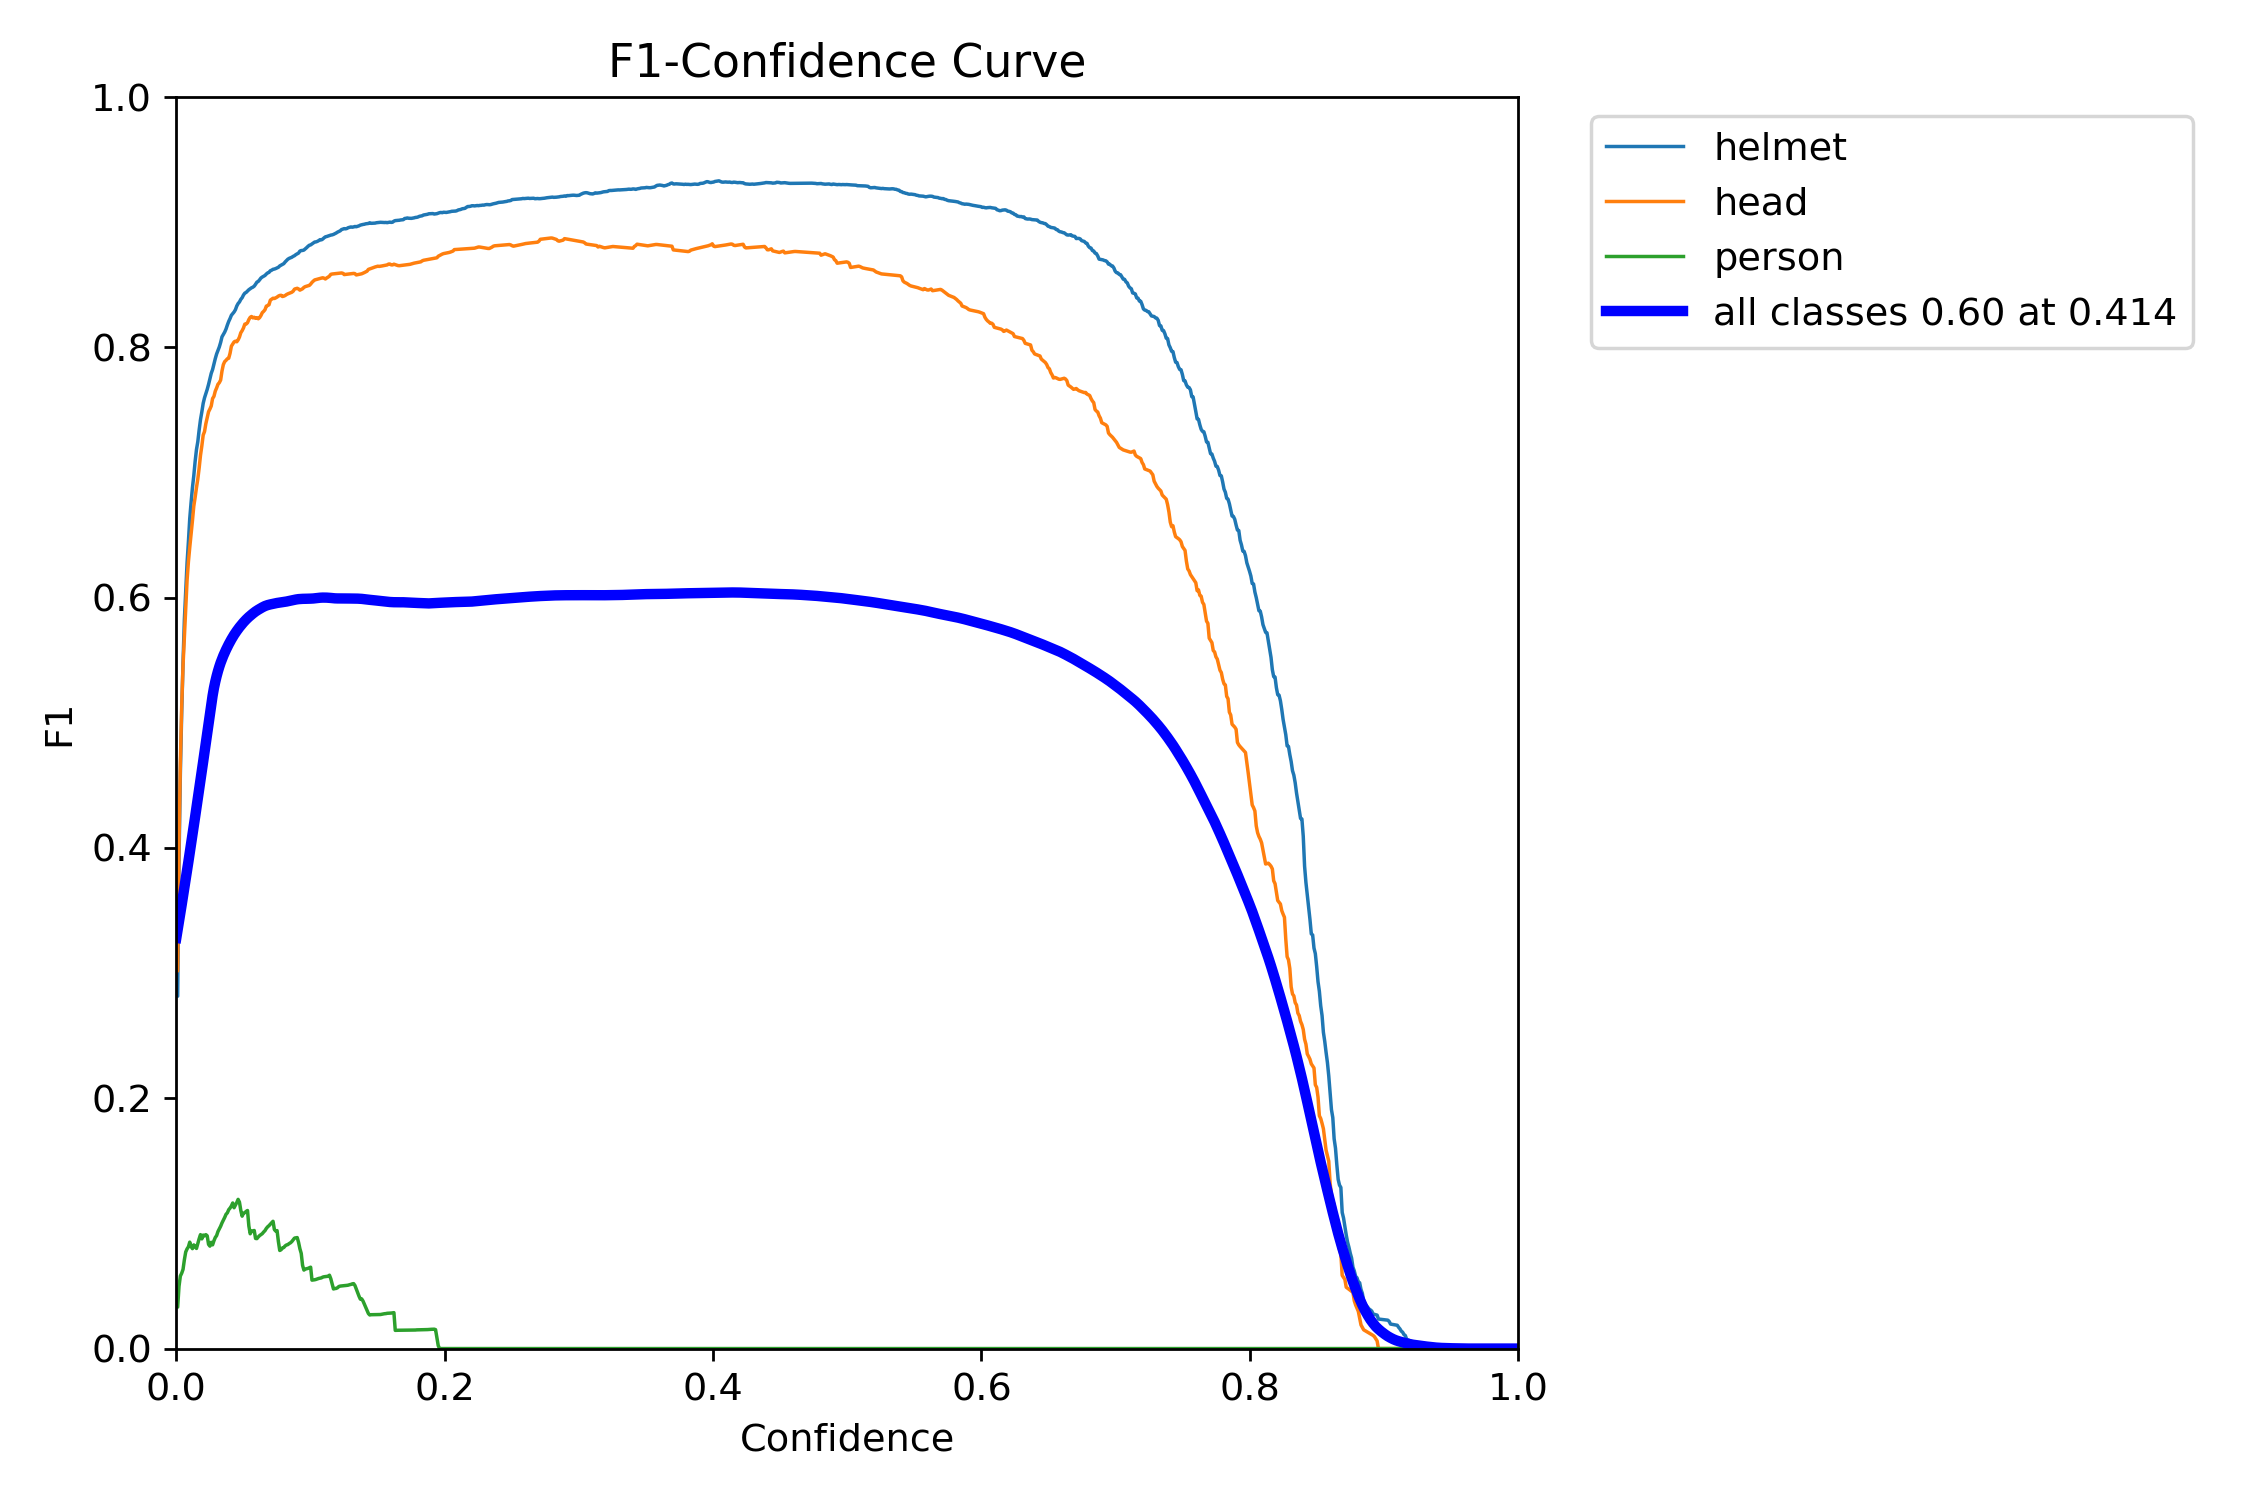

In [20]:
Image(filename='/kaggle/working/runs/detect/train/F1_curve.png', width=600)

In [21]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

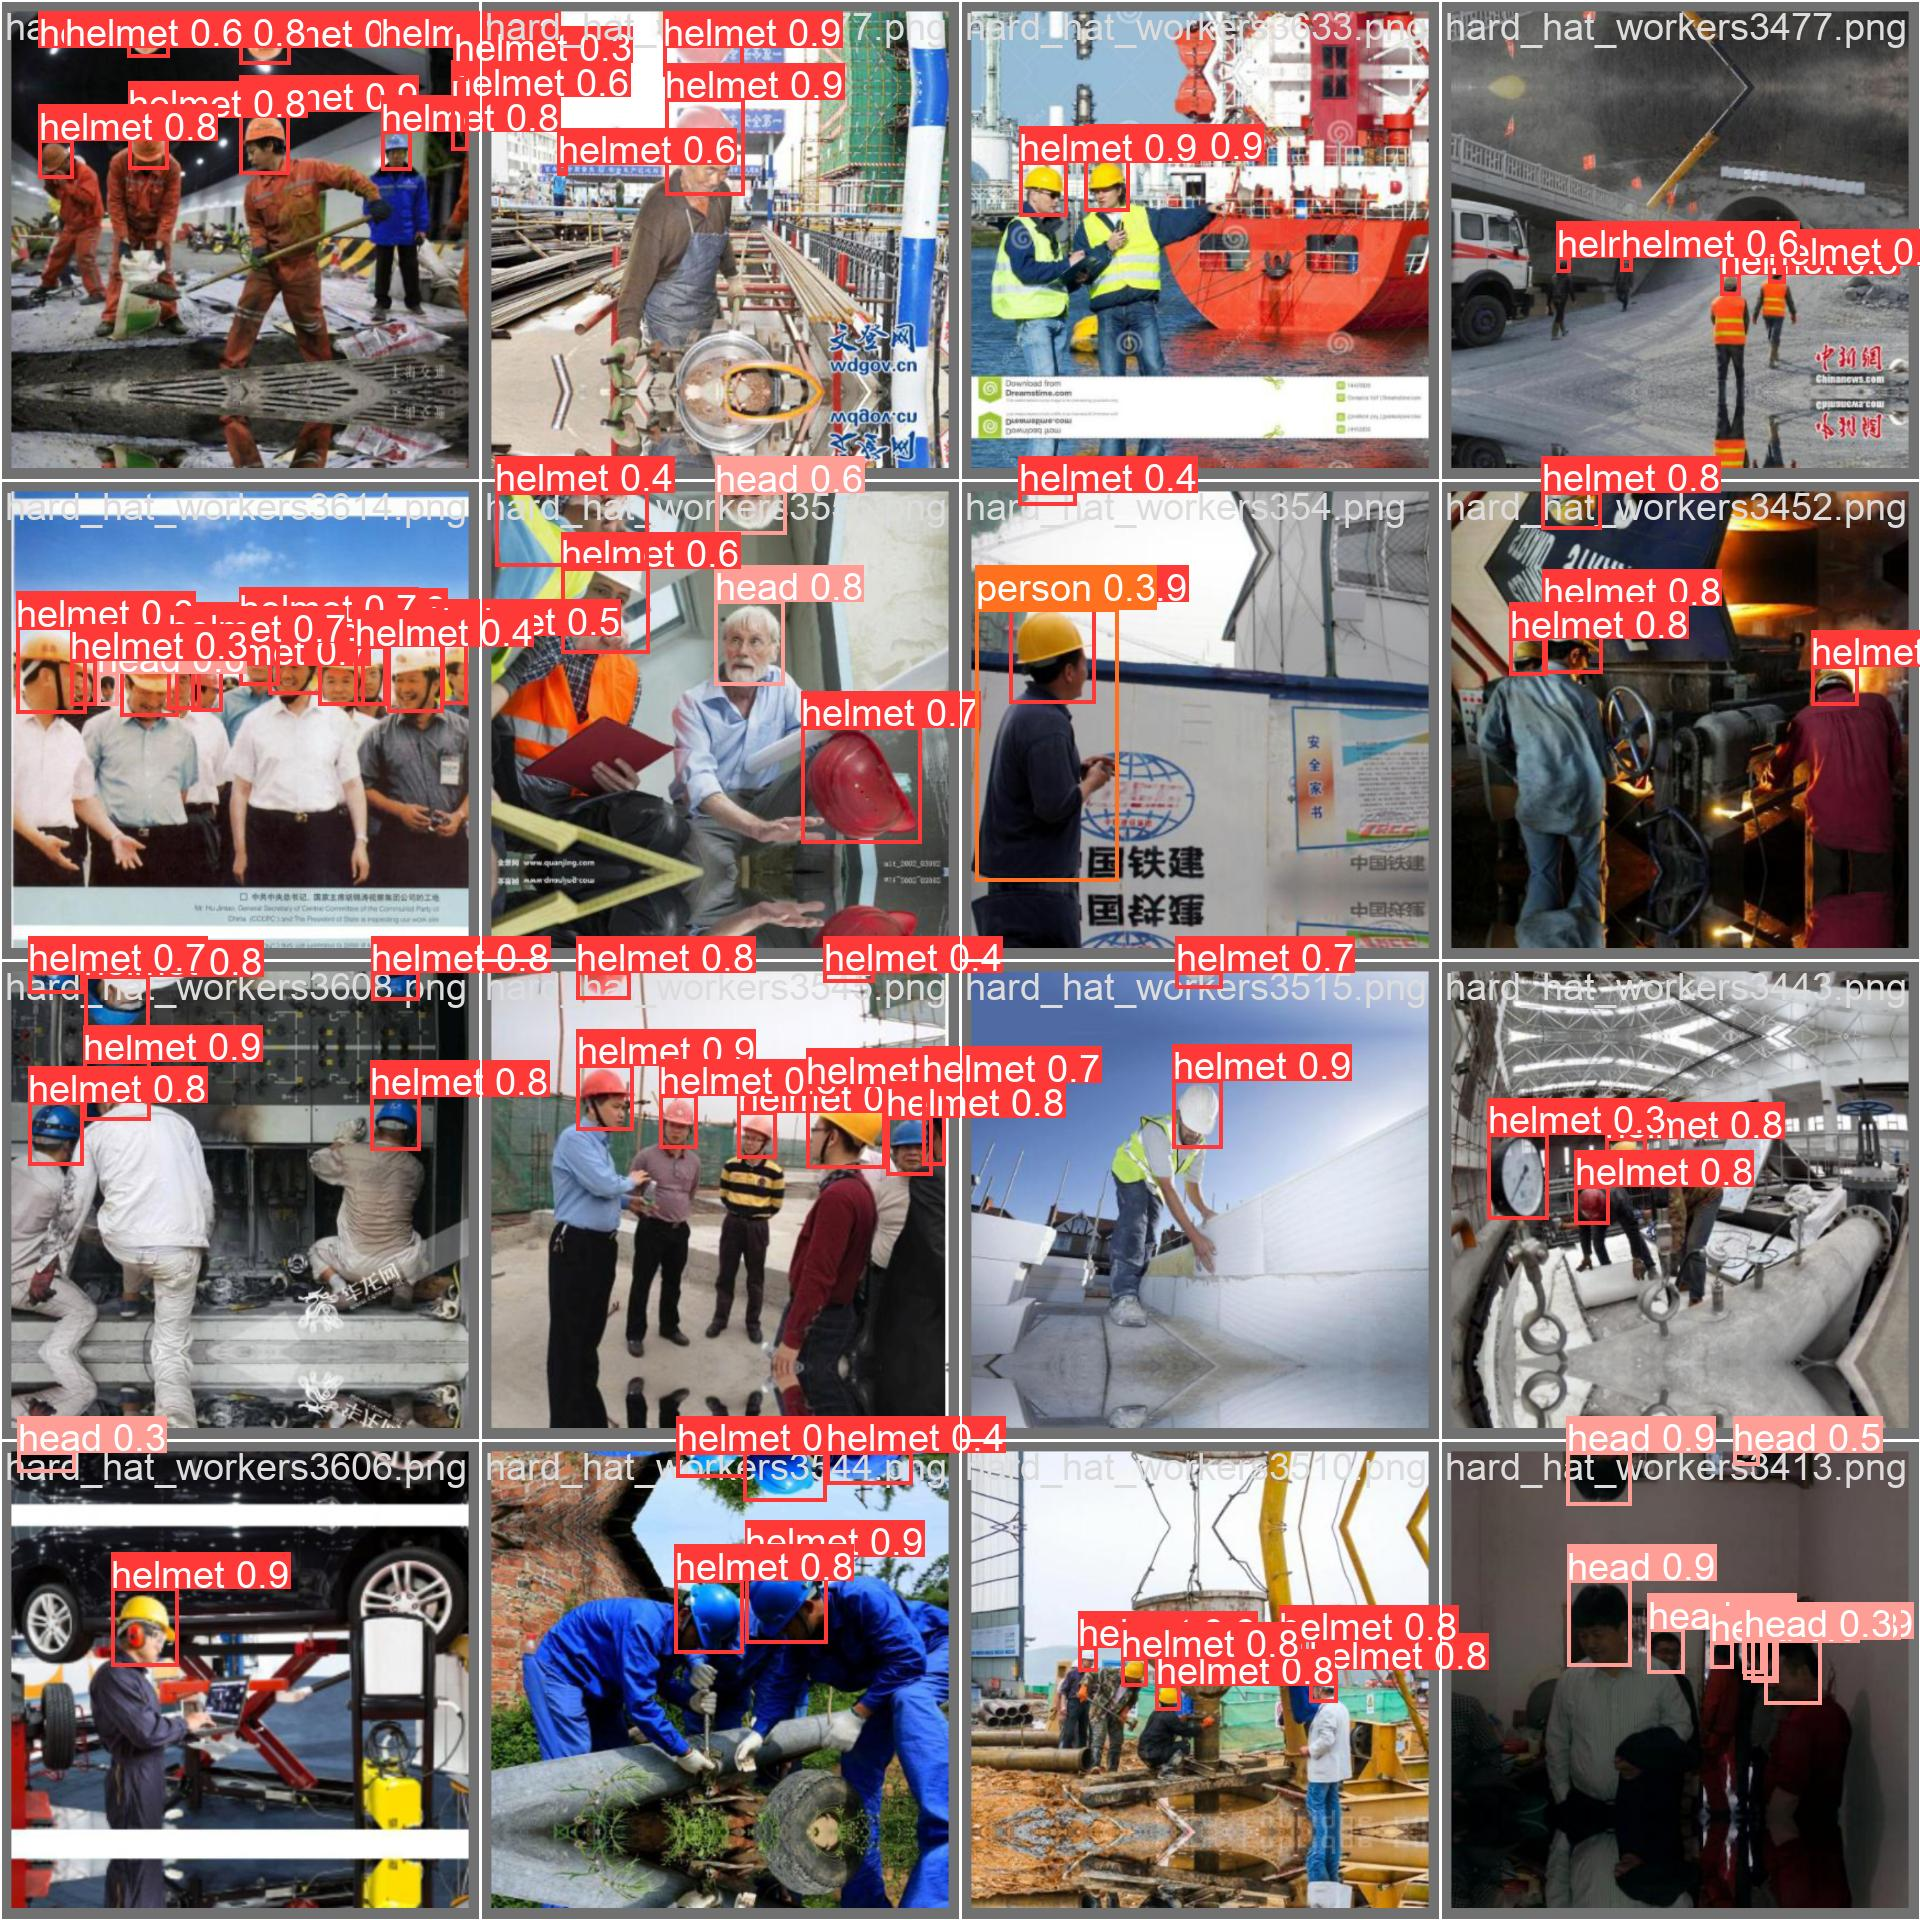

In [22]:
Image(filename='/kaggle/working/runs/detect/train/val_batch0_pred.jpg', width=1000)

In [23]:
# to run validation on a trained YOLO model
# Indicates that the mode is validation. In this mode, 
# the model will run inference on the validation dataset to evaluate its performance
# Validation helps assess how well the model generalizes to unseen data

!yolo task=detect mode=val model=/kaggle/working/runs/detect/train/weights/best.pt data=data.yaml

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Ultralytics YOLOv8.0.91 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/Dataset/labels/val.cache... 500 images, 0 backgrou
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        500       2422      0.624      0.585       0.64      0.421
                helmet        500       1922      0.956       0.91      0.963      0.631
                  head        500        396      0.916      0.843      0.913      0.609
                person        500        104          0          0     0.0444     0.0228
Speed: 1.4ms preprocess, 9.4ms inference, 0.0ms loss, 1.4ms postproces